# Exploring Brain-Wide Outputs to the Secondary Motor Cortex with the Allen Connectivity Atlas

This project shows how the Allen Mouse Brain Connectivity Atlas can be used to investigate where inputs to a specific brain area come from. Using projection density data from multiple tracer experiments, the code groups injections by source region and looks at how strongly they project to other brain areas.

# 1. Set up
Packages to install and import

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import os
import nrrd
import imageio.v2 as imageio
warnings.filterwarnings('ignore')
%matplotlib inline

Import now data from the allen sdk repository

In [2]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# MouseConnectivityCache has a method for retrieving the adult mouse structure 
# tree as an StructureTree class instance. This is a wrapper around a list of 
# dictionaries, where each dictionary describes a structure. 
# It is principally useful for looking up structures by their properties

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json') #relative path

In [3]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree() # To see only structure sets relevant to the adult mouse brain, use the StructureTree

# get info on some structures
structures = structure_tree.get_structures_by_acronym(['AUD'])# You can also .get_structures_by_name(['Secondary motor area'])
print(structures)

[{'acronym': 'AUD', 'graph_id': 1, 'graph_order': 121, 'id': 247, 'name': 'Auditory areas', 'structure_id_path': [997, 8, 567, 688, 695, 315, 247], 'structure_set_ids': [3, 112905828, 691663206, 12, 184527634, 114512891], 'rgb_triplet': [1, 147, 153]}]


In [4]:
# On the connectivity atlas web site, they show most of data at a fairly coarse structure level. 
# They did this by creating a structure set of ~300 structures, which we call the "summary structures". 
# We can use the structure tree to get all of the structures in this set
from allensdk.api.queries.ontologies_api import OntologiesApi

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# 2. Function set up
A bunch of functions to run the code

In [7]:
# Function that creates a maximum intensity projection of the data along a given axis,
# overlayed with a background image created from the template.Colormap is set to 'afmhot' for the data

def axis_proj(data, template, axis, bg_q=90, bg_alpha=0.5):
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=plt.cm.afmhot)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

In [ ]:
# Define custom colormap: to choose your own colors, visit this site: 
# https://coolors.co/gradient-maker/000000-234622-4e9a4a-ffffff?position=0,33,66,100&opacity=100,100,100,100&type=linear&rotation=90
# Then copy the hex values and paste them below
# You can add more colors if you want, just make sure the first value is black (#000000) at 0.00 and the last value is white (#FFFFFF) at 1.00
# The values in between should be between 0 and 1, and in increasing order

green_palette = [(0.00, "#000000"),
                 (0.33, "#018217"),
                 (0.66, "#52FC19"),
                 (1.00, "#FFFFFF")
                 ]

blue_palette = [(0.00, "#000000"),
                (0.33, "#0055FF"),
                (0.66, "#1AB5FD"),
                (1.00, "#FFFFFF")
                ]

magenta_palette = [(0.00, "#000000"),
                   (0.33, "#820177"),
                   (0.66, "#FC19A5"),
                   (1.00, "#FFFFFF")
                   ]

red_palette = [(0.00, "#000000"),
               (0.33, "#6F0909"),
               (0.66, "#CC1111"),
               (1.00, "#FFFFFF")
               ]


# Create colormap
custom_green_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_cmap", green_palette)
custom_blue_cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue_cmap", blue_palette)
custom_magenta_cmap = mcolors.LinearSegmentedColormap.from_list("custom_magenta_cmap", magenta_palette)
custom_red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red_cmap", red_palette)

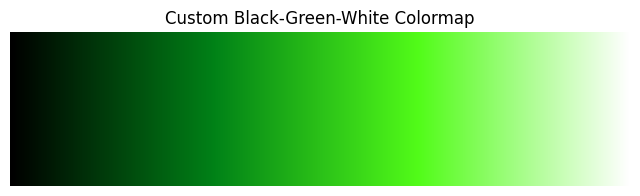

In [9]:
# Show colormap example
gradient = np.linspace(0, 1, 256).reshape(1, -1)  # Create a gradient for visualization
plt.figure(figsize=(8, 2))
plt.imshow(gradient, aspect='auto', cmap=custom_green_cmap)
plt.axis('off')
plt.title("Custom Black-Green-White Colormap")
plt.show()

In [10]:
# Function that creates a maximum intensity projection of the data along a given axis,
# overlayed with a background image created from the template.Colormap is set to 'custom_green_cmap' for the data

def axis_proj_green(data, template, axis, bg_q=90, bg_alpha=0.5):
    """
    To plot the density projections with the green colorbar
    """
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=custom_green_cmap)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

In [11]:
# Function that creates a maximum intensity projection of the data along a given axis,
# overlayed with a background image created from the template.Colormap is set to 'custom_blue_cmap' for the data

def axis_proj_blue(data, template, axis, bg_q=90, bg_alpha=0.5):
    """
    To plot the density projections with the blue colorbar
    """
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=custom_blue_cmap)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

In [12]:
# Function that creates a maximum intensity projection of the data along a given axis,
# overlayed with a background image created from the template.Colormap is set to 'custom_magenta_cmap' for the data

def axis_proj_magenta(data, template, axis, bg_q=90, bg_alpha=0.5):
    """
    To plot the density projections with the magenta colorbar
    """
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=custom_magenta_cmap)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

In [13]:
# Function that creates a maximum intensity projection of the data along a given axis,
# overlayed with a background image created from the template.Colormap is set to 'custom_green_cmap' for the data
# Additionally, overlays outlines of specified structure masks

def axis_proj_green_outline(data, template, axis, bg_q=90, bg_alpha=0.5, structure_masks=None, default_color="white"):
    """
    Plot density projections in green with an outline for specified structure masks.
    """
    # Projection of data & template
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)

    ax = plt.gca()  # use current axes

    # Plot projections
    ax.imshow(data_max, interpolation='none', cmap=custom_green_cmap)
    ax.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=bg_alpha)
    ax.axis('off')

    # Overlay outlines for each structure
    if structure_masks is not None:
        mask_proj = np.amax(structure_masks, axis=axis)
        if np.any(mask_proj):
            ax.contour(mask_proj, levels=[0.5], colors=default_color, linewidths=0.8)

In [ ]:
def slice_overlay(prdens_matrix, template, slice_index, axis=1, ax=None, bg_q=90, bg_alpha=0.5, structure_masks=None):
    """
    Overlay a 2D slice of projection density data on an anatomical template with optional structure outlines
    Parameters:
    - prdens_matrix: 3D numpy array of projection density data
    - template: 3D numpy array of anatomical template data
    - slice_index: Index of the slice to display
    - axis: Axis along which to take the slice (0, 1, or 2)
    - ax: Matplotlib Axes object to plot on (creates new if None)
    - bg_q: Percentile for background template contrast
    - bg_alpha: Alpha transparency for background template
    - structure_masks: Dictionary of structure masks to overlay (keys are region names, values are tuples of (mask_array, color))
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Select the appropriate 2D slice
    if axis == 0:
        pm_slice = prdens_matrix[slice_index, :, :]
        bg_slice = template[slice_index, :, :]
    elif axis == 1:
        pm_slice = prdens_matrix[:, slice_index, :]
        bg_slice = template[:, slice_index, :]
    elif axis == 2:
        pm_slice = prdens_matrix[:, :, slice_index]
        bg_slice = template[:, :, slice_index]
    else:
        raise ValueError("Axis must be 0, 1, or 2")
    

    # Plot projection density overlay
    ax.imshow(pm_slice, cmap= custom_magenta_cmap, interpolation='none')

     # Plot anatomical background
    ax.imshow(bg_slice, cmap='gray', alpha=bg_alpha, interpolation='none')

    # Overlay the structure mask (e.g., MOs)
    if structure_masks is not None:
        for region_name, (mask, color) in structure_masks.items():
            # Extract slice for the current axis
            if axis == 0:
                mask_slice = mask[slice_index, :, :]
            elif axis == 1:
                mask_slice = mask[:, slice_index, :]
            elif axis == 2:
                mask_slice = mask[:, :, slice_index]
            else:
                raise ValueError("Invalid axis. Use 0, 1, or 2.")
            # Plot contour if the mask slice has nonzero data
            if np.any(mask_slice):
                ax.contour(mask_slice, levels=[0.5], colors=color, linewidths=1)
    
    ax.axis('off')

# 3. Structure signal unionization
The ProjectionStructureUnionizes API data tells you how much signal there was in a given structure and experiment. It contains the density of projecting signal, volume of projecting signal, and other information. MouseConnectivityCache provides methods for querying and storing this data.

For this following section, to know which is the acronym of the area(s) you are interested in, first visit the allen brain atlas website
https://atlas.brain-map.org/atlas?atlas=602630314#atlas=602630314&plate=576989940&structure=549&x=5279.999781366604&y=3744.0785151809005&zoom=-3&resolution=NaN&z=3

Get data for single experiments - to retreive them, you can use this block of code, else go to the allen connectivity website if you want to be more specific and see which other options are available for selecting experiments
https://connectivity.brain-map.org/

In [15]:
# find injections into visual areas (considering both cre and wild-type lines)
mos = structure_tree.get_structures_by_acronym(['MOs'])[0]
mos_experiments_wt = mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[mos['id']])
mos_experiments_cre = mcc.get_experiments(cre=True,
                                       injection_structure_ids=[mos['id']])
mos_experiments = mos_experiments_wt + mos_experiments_cre
print("%d MOs experiments" % len(mos_experiments))

145 MOs experiments


In [16]:
experiment_ids_mos = []

mos_id = mos['id']
for exp in mos_experiments:
    experiment_ids_mos.append(exp['id'])

In [ ]:
for exp in mos_experiments:
    print(f"Experiment ID: {exp['id']}, Additional Info: {exp}")

# 4. Manipulating grid data
The MouseConnectivityCache class also helps you download and open every experiment's projection grid data volume. By default it will download 25um volumes, but you could also download data at other resolutions if you prefer (10um, 50um, 100um).

This demonstrates how you can load the projection density for a particular experiment. It also shows how to download the template volume to which all grid data is registered. Voxels in that template have been structurally annotated by neuroanatomists and the resulting labels stored in a separate annotation volume image.

In [17]:
# injection into MOs as example
experiment_id = 294525944 

In [18]:
# projection density: number of projecting pixels / voxel volume
proj_d, proj_d_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# data mask:
# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)

template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# in addition to the annotation volume, you can get binary masks for individual structures
# in this case, we'll get one for the MOs
cortex_mask, cm_info = mcc.get_structure_mask(993)

print(proj_d_info)
print(proj_d.shape, template.shape, annot.shape)

OrderedDict([('type', 'double'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([528, 320, 456])), ('space directions', array([[25.,  0.,  0.],
       [ 0., 25.,  0.],
       [ 0.,  0., 25.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])
(528, 320, 456) (528, 320, 456) (528, 320, 456)


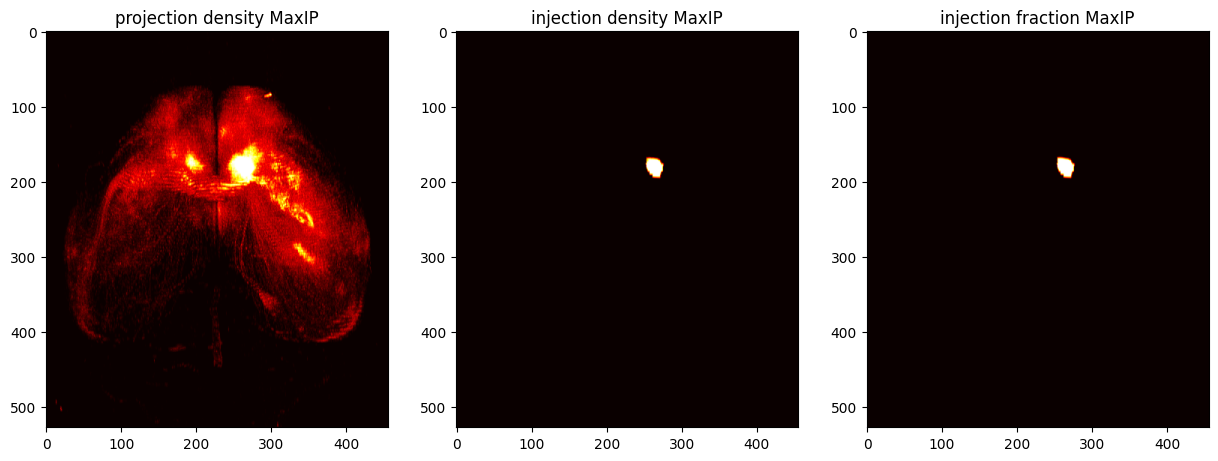

In [19]:
# compute the maximum intensity projection (along the anterior-posterior axis) of the projection data
proj_d_mip = proj_d.max(axis=1)
ind_mip = ind.max(axis=1)
inf_mip = inf.max(axis=1)

# show that slice of all volumes side-by-side
f, pr_axes = plt.subplots(1, 3, figsize=(15, 6))

pr_axes[0].imshow(proj_d_mip, cmap='hot', aspect='equal')
pr_axes[0].set_title("projection density MaxIP")

pr_axes[1].imshow(ind_mip, cmap='hot', aspect='equal')
pr_axes[1].set_title("injection density MaxIP")

pr_axes[2].imshow(inf_mip, cmap='hot', aspect='equal')
pr_axes[2].set_title("injection fraction MaxIP")

plt.show()

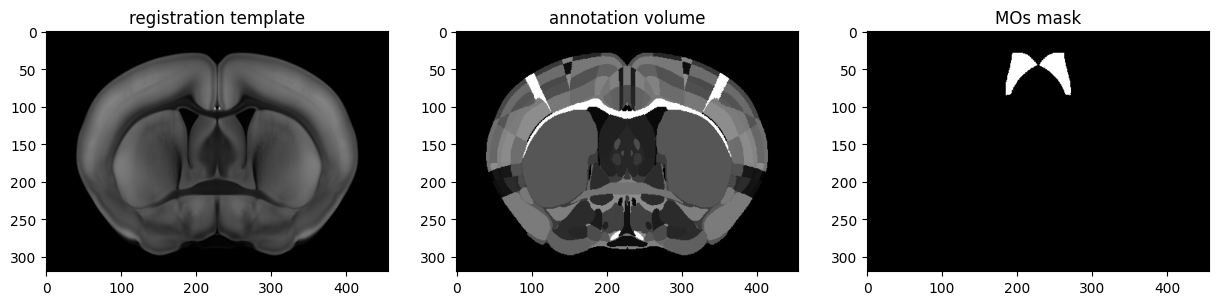

In [20]:
# Look at a slice from the average template and annotation volumes

# pick a slice to show
slice_idx = 210

f, ccf_axes = plt.subplots(1, 3, figsize=(15, 6))

ccf_axes[0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0].set_title("registration template")

ccf_axes[1].imshow(annot[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
ccf_axes[1].set_title("annotation volume")

ccf_axes[2].imshow(cortex_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[2].set_title("MOs mask")

plt.show()

# 5. Working in 3D
Allen Institute has generated an average template volume from 1675 mouse brain image stacks and registering each connectivity datasets to this average template. This allows us to work in a shared 3d space, which we call the Common Coordinate Framework (CCF).
You can view the average template volume using your MouseConnectivityCache.

The template is oriented:

anterior -> posterior

superior -> inferior

left -> right

This means that to obtain a sagittal view, we must slice along axis 2, and along axis 1 for a horizontal section (0=coronal, 1=horizontal, 2=sagittal):

(528, 320, 456)


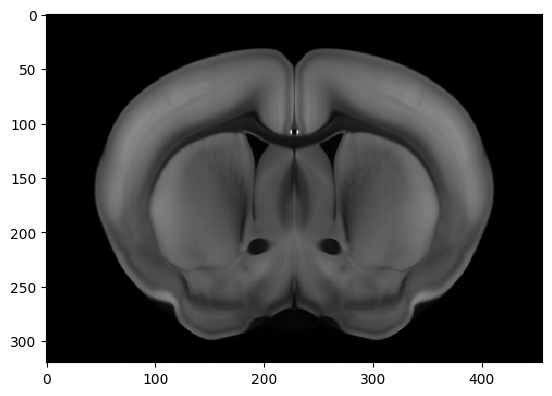

In [21]:
# load up the average template
template, header = mcc.get_template_volume()

# recall that this cache is at 25 micron isometric resolution
plt.imshow(template[200, :, :], interpolation='none', cmap=plt.cm.gray)

# how big?
print(template.shape)

# 6. The annotation volume

Each (brain) voxel in the CCF is associated with a structure in the structure tree. This mapping is recorded in the annotation volume, which occupies the same space as the average template. The value of each voxel in the annotation volume is the id of the most specific structure occupying that point in space.

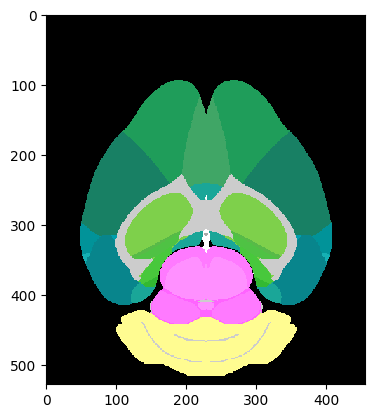

In [ ]:
# you can obtain a reference space object from your mouse connectivity cache
# this object handles tasks that require both a structure tree and an annotation volume
reference_space =  mcc.get_reference_space()

# One such task is to apply our predefined structure colors to 
# a slice from the annotation volume
slice_image = reference_space.get_slice_image(1, 1875) # this method wants an axis and a position in microns
plt.imshow(slice_image, interpolation='none')

# 8. Structure Mask
The annotation volume and structure tree contain a lot of information in a compact form. It can be simpler to work with more explicit representations of individual structures. We often use binary indicator masks for specific structures. These are:

volumes in the common coordinate framework

1 where the annotation is labeled with a structure or its descendants, otherwise 0

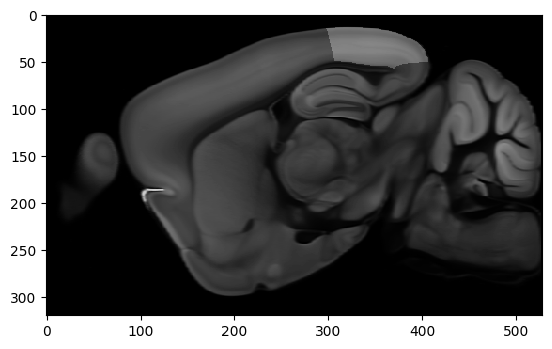

In [23]:
# view a structure mask for MOs
VIS_mask, _ = mcc.get_structure_mask(669)
plt.imshow(VIS_mask[:, :, 150].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 150].T, interpolation='none', cmap=plt.cm.gray, alpha=0.8)


# 9. Gridded projection data
Since each connectivity experiment is registered to the CCF, we can load connectivity data in the same way as we do the average template or annotation volume.

Here we will load an experiment's projection density volume. These data:

- are floats in [0, 1]

- represent the fraction of each voxel that is occupied by signal (as detected in the segmentation stage)

- are independent of the injection site (so it makes sense to discuss "projection in the injection site")

In [24]:
prdens, _ = mcc.get_projection_density(experiment_id) #example experiment

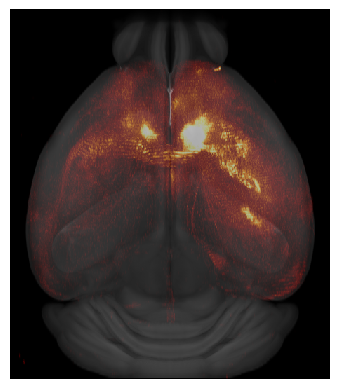

In [25]:
# make a max projection along the anterior-posterior axis for visualization
axis_proj(prdens, template, 1)

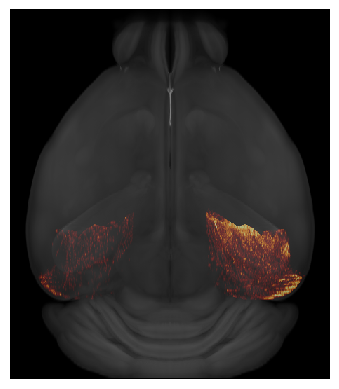

In [26]:
# now filter the signal to MOs

prdens_VIS =prdens.copy()
prdens_VIS[VIS_mask == 0] = 0
axis_proj(prdens_VIS, template, 1)

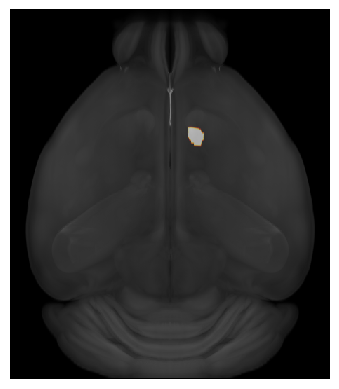

In [27]:
# Another useful data volume is the injection fraction. This shows the fraction of each voxel that lies within
# this experiment's manually annotated injection site
ijfr, _ = mcc.get_injection_fraction(experiment_id)
axis_proj(ijfr, template, 1)

In [ ]:
import nrrd  # pip install pynrrd

# Where to save results
out_folder = r"C:\Users\Nicole\OneDrive - Fondazione Istituto Italiano Tecnologia\Desktop\Dottorato\Esperimenti\AllenConnectivity\AllenSDK_scripts\averages"
os.makedirs(out_folder, exist_ok=True)

# Reference header (so saved files have the same format as Allen’s)
ref_file = r"C:\Users\Nicole\OneDrive - Fondazione Istituto Italiano Tecnologia\Desktop\Dottorato\Esperimenti\AllenConnectivity\AllenSDK_scripts\connectivity\experiment_294525944\projection_density_25.nrrd"  # one downloaded file
ref_data, ref_header = nrrd.read(ref_file)

# ---------------- MOs ----------------
average_prdens_mos = None

for exp_id in experiment_ids_mos:
    prdens_mos, _ = mcc.get_projection_density(exp_id)
    if average_prdens_mos is None:
        average_prdens_mos = np.zeros_like(prdens_mos, dtype=np.float32)
    average_prdens_mos += prdens_mos

average_prdens_mos /= len(experiment_ids_mos)

# Save as .nrrd
mos_out_path = os.path.join(out_folder, "average_prdens_mos.nrrd")
nrrd.write(mos_out_path, average_prdens_mos.astype(ref_data.dtype), header=ref_header)
print(f"Saved MOs average projection density → {mos_out_path}")

2025-10-14 15:25:24,487 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/100141454?image=projection_density&resolution=25
2025-10-14 15:25:52,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/141603190?image=projection_density&resolution=25
2025-10-14 15:26:04,731 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/180709942?image=projection_density&resolution=25
2025-10-14 15:26:12,927 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/180719293?image=projection_density&resolution=25
2025-10-14 15:26:19,932 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/141602484?image=projection_density&resolution=25
2025-10-14 15:26:33,233 allensdk.api.api.retrieve_file_

Saved MOs average projection density → C:\Users\Nicole\OneDrive - Fondazione Istituto Italiano Tecnologia\Desktop\Dottorato\Esperimenti\AllenConnectivity\AllenSDK_scripts\averages\average_prdens_mos.nrrd


In [28]:
import nrrd  
# Paths where you saved the files
mos_file = r"C:\Users\Nicole\OneDrive - Fondazione Istituto Italiano Tecnologia\Desktop\Dottorato\Esperimenti\AllenConnectivity\AllenSDK_scripts\averages\average_prdens_mos.nrrd"

# Read back into numpy arrays
average_prdens_mos, mos_header = nrrd.read(mos_file)

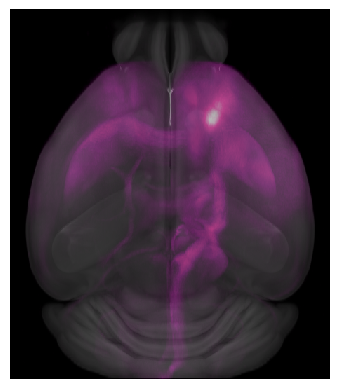

In [29]:
axis_proj_magenta(average_prdens_mos, template, 1)

In [30]:
#Get masks from multiple frontal areas
# MO_mask, _ = mcc.get_structure_mask(500)
# ACA_mask, _ = mcc.get_structure_mask(31)
# PL_mask, _ = mcc.get_structure_mask(972)
# ILA_mask, _ = mcc.get_structure_mask(44)
# ORB_mask, _ = mcc.get_structure_mask(714)
# AI_mask, _ = mcc.get_structure_mask(95)

VIS_mask, _ = mcc.get_structure_mask(669)
AUD_mask, _ = mcc.get_structure_mask(247)

# Combined_frontal_mask = MO_mask | ACA_mask | PL_mask | ILA_mask | ORB_mask | AI_mask
Combined_sensory_mask = VIS_mask | AUD_mask

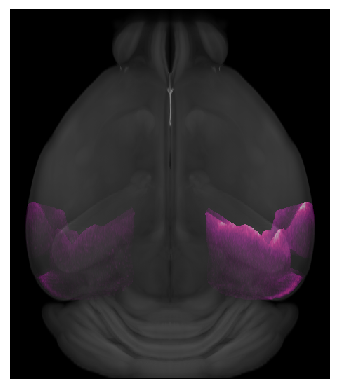

In [31]:
# You can visualize data only to the selected areas, by using a mask

prdens_sensory = average_prdens_mos.copy()
prdens_sensory[Combined_sensory_mask == 0] = 0
axis_proj_magenta(prdens_sensory, template, 1)

Now we create a combined array between the averaged MOs projection density array, and the valid pixels in the very same array.
First, we check which pixels are valid and active, we'll use a threshold to determine this.

Projection density value Range in MOs matrix: 0.0 0.2054210603237152
Active pixels in mos: 4169255


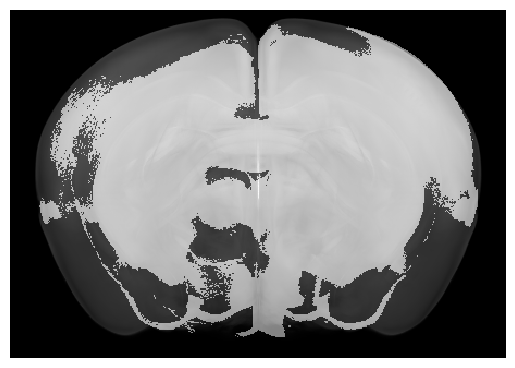

In [32]:
# Define threshold for active pixels
print("Projection density value Range in MOs matrix:", np.nanmin(average_prdens_mos), np.nanmax(average_prdens_mos))
threshold = 0.015 # 0.03 was the value I first used, but you can change it according to how conservative you want to be

# Find active pixels in both datasets
active_mos = average_prdens_mos > threshold
print("Active pixels in mos:", np.count_nonzero(active_mos)) #check number of True pixels in mos matrix

# Visualize the averaged projection density
axis_proj(active_mos, template, 0)  # Example: max projection

plt.show()

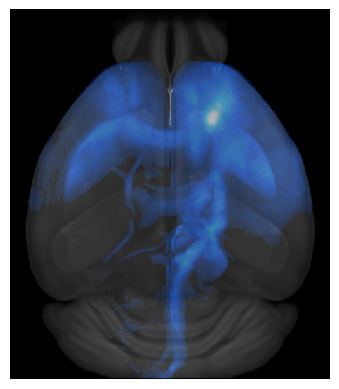

In [33]:
# Initialize combined projection density map
combined_prdens = np.zeros_like(average_prdens_mos)

# Assign combined densities where overlap is active
combined_prdens[active_mos] = (
    average_prdens_mos[active_mos]
)

# Now we can visualize the combined projection density map
axis_proj_blue(combined_prdens, template, 1)

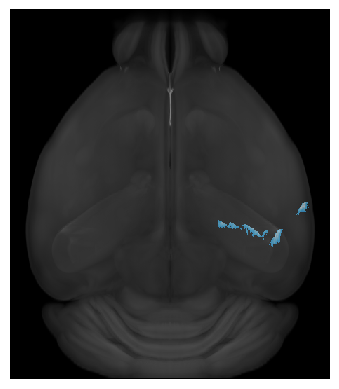

In [34]:
# You can visualize data also in one single specific area, by using a mask (selecting valid pixels only in AUD and VIS areas)

prdens_sensory = combined_prdens.copy()
prdens_sensory[Combined_sensory_mask == 0] = 0
axis_proj_blue(prdens_sensory, template, 1)

In [35]:
#Get masks from multiple frontal areas
VIS_mask, _ = mcc.get_structure_mask(669)
MO_mask, _ = mcc.get_structure_mask(500) # 500 is the structure ID for MO (MOs + MOp)
VISpl_mask, _ = mcc.get_structure_mask(425)
VISp_mask, _ = mcc.get_structure_mask(385)
VISpm_mask, _ = mcc.get_structure_mask(533)
VISpor_mask, _ = mcc.get_structure_mask(312782628)
VISl_mask, _ = mcc.get_structure_mask(409)
VISal_mask, _ = mcc.get_structure_mask(402)
VISli_mask, _ = mcc.get_structure_mask(312782574)
VISam_mask, _ = mcc.get_structure_mask(394)
VISa_mask,_ = mcc.get_structure_mask(312782546)
VISrl_mask, _ = mcc.get_structure_mask(417)
AUDd_mask, _ = mcc.get_structure_mask(1011)
AUDp_mask, _ = mcc.get_structure_mask(1002)
AUDv_mask, _ = mcc.get_structure_mask(1018)
AUDpo_mask, _ = mcc.get_structure_mask(1027)

region_masks_mos_vis = {
    #'MOs':     (MOs_mask),
    'VIS':     (VIS_mask),
    'AUD':     (AUD_mask),
    # 'VISa':    (VISa_mask),
    # 'VISrl':   (VISrl_mask),

}

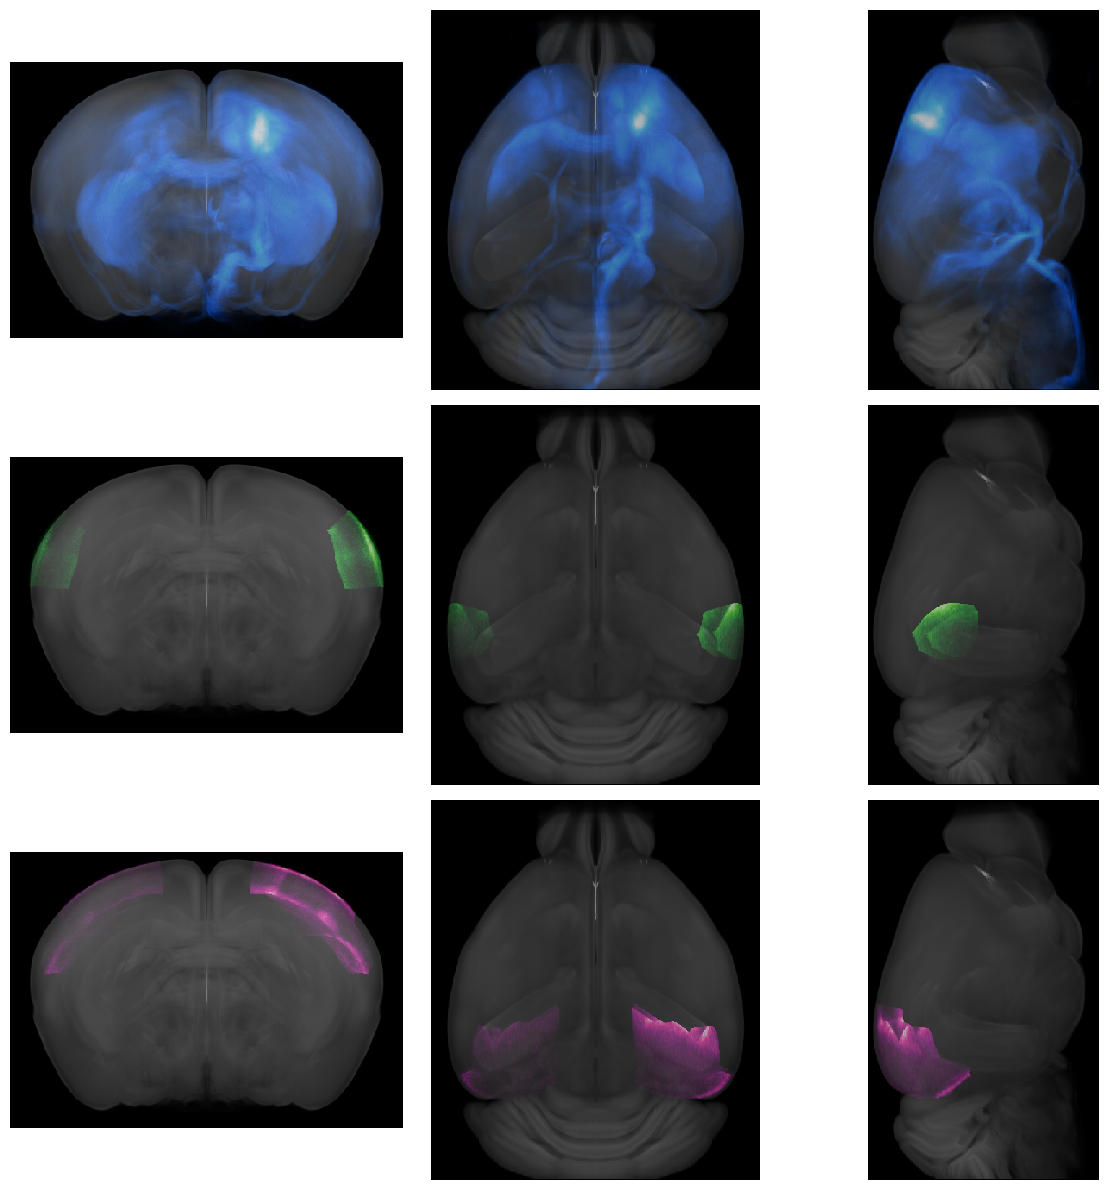

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# --- Row 1: All (blue) ---
plt.sca(axes[0, 0]); axis_proj_blue(average_prdens_mos, template, 0)
plt.sca(axes[0, 1]); axis_proj_blue(average_prdens_mos, template, 1)
plt.sca(axes[0, 2]); axis_proj_blue(average_prdens_mos, template, 2)

# --- Row 2: AUDITORY (green) ---
prdens_mos_aud = average_prdens_mos.copy()
prdens_mos_aud[AUD_mask == 0] = 0
plt.sca(axes[1, 0]); axis_proj_green(prdens_mos_aud, template, 0)
plt.sca(axes[1, 1]); axis_proj_green(prdens_mos_aud, template, 1)
plt.sca(axes[1, 2]); axis_proj_green(prdens_mos_aud, template, 2)

# --- Row 3: VISUAL (magenta) ---
prdens_mos_vis = average_prdens_mos.copy()
prdens_mos_vis[VIS_mask == 0] = 0
plt.sca(axes[2, 0]); axis_proj_magenta(prdens_mos_vis, template, 0)
plt.sca(axes[2, 1]); axis_proj_magenta(prdens_mos_vis, template, 1)
plt.sca(axes[2, 2]); axis_proj_magenta(prdens_mos_vis, template, 2)


plt.tight_layout()
# plt.savefig('AUD_VIS_MOs_allProj.svg', format='svg')
plt.show()

In [37]:
#I want to find MOs (id=993) different layers ids
MOs_children = structure_tree.children([993])[0]
pd.DataFrame(MOs_children)

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,MOs1,1,25,656,"Secondary motor area, layer 1","[997, 8, 567, 688, 695, 315, 500, 993, 656]","[667481440, 184527634, 12, 691663206]","[31, 157, 90]"
1,MOs2/3,1,26,962,"Secondary motor area, layer 2/3","[997, 8, 567, 688, 695, 315, 500, 993, 962]","[667481441, 184527634, 12, 691663206]","[31, 157, 90]"
2,MOs5,1,27,767,"Secondary motor area, layer 5","[997, 8, 567, 688, 695, 315, 500, 993, 767]","[184527634, 12, 667481446, 691663206]","[31, 157, 90]"
3,MOs6a,1,28,1021,"Secondary motor area, layer 6a","[997, 8, 567, 688, 695, 315, 500, 993, 1021]","[667481449, 184527634, 12, 691663206]","[31, 157, 90]"
4,MOs6b,1,29,1085,"Secondary motor area, layer 6b","[997, 8, 567, 688, 695, 315, 500, 993, 1085]","[184527634, 12, 667481450, 691663206]","[31, 157, 90]"


In [38]:
# Get masks from different MOs layers
MOs_mask, _ = mcc.get_structure_mask(993)
MOs1_mask, _ = mcc.get_structure_mask(656)
MOs2_3_mask, _ = mcc.get_structure_mask(962)
MOs5_mask, _ = mcc.get_structure_mask(767)
MOs6a_mask, _ = mcc.get_structure_mask(1021)
MOs6b_mask, _ = mcc.get_structure_mask(1085)
combined_mask = (
    MOs1_mask |
    MOs2_3_mask |
    MOs5_mask |
    MOs6a_mask |
    MOs6b_mask
)

In [39]:
# Define structure masks with colors for outlines
region_masks = {
    'MOs':     (MOs_mask, 'red'),
    'MOs1':    (MOs1_mask, 'grey'),
    'MOs2/3':  (MOs2_3_mask, 'grey'),
    'MOs5':    (MOs5_mask, 'grey'),
    'MOs6a':   (MOs6a_mask, 'grey'),
    'MOs6b':   (MOs6b_mask, 'grey')
}

In [40]:
combined_mask = (
    VIS_mask |
    AUD_mask
)

region_masks = {
    'VIS':     (VIS_mask, 'green'),
    'AUD':     (AUD_mask, 'blue')
}

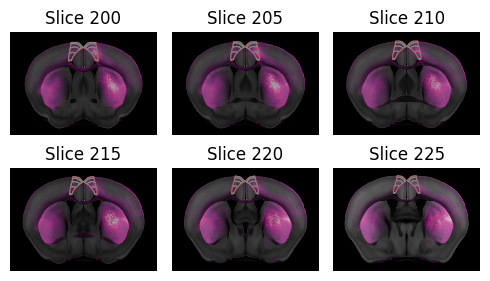

In [64]:
# Now visualize selectivity index on different coronal slices with colored outlines of MOs layers

from matplotlib.colors import hsv_to_rgb, Normalize, LinearSegmentedColormap

# Settings
start_slice = 20 # we select the slices where MOs is present
end_slice = 150
step = 5
axis = 1  # e.g., 0 = coronal, 1 = horizontal, 2 = sagittal
fig, axes = plt.subplots(2, 3, figsize=(5,3))
axes = axes.flatten()

for i in range(6):
    slice_idx =200 + i * 5
    ax = axes[i]
    slice_overlay(
        average_prdens_mos,
        template,
        slice_index=slice_idx,
        axis=0,
        ax=ax,
        structure_masks=region_masks  # Pass the dict of region masks + colors
    )
    ax.set_title(f"Slice {slice_idx}")

plt.tight_layout()



You can also save these different slices in a gif, to have a fancy video to look at, to better understand MOs projection to the rest of the brain, without having to look at them through a projection representation

In [68]:
import imageio.v2 as imageio
import os

# Create directory to store frames
filenames = []

# Generate frames with higher resolution (e.g., 6 inches × 4 inches at 100 DPI)
for i in range(263):
    slice_idx = 0 + i * 2
    fig, ax = plt.subplots(figsize=(10, 12), dpi=100)

    slice_overlay(
        average_prdens_mos,
        template,
        slice_index=slice_idx,
        axis=0,
        ax=ax,
        structure_masks=region_masks  # Pass the dict of region masks + colors
    )
    
    ax.set_title(f"Slice {slice_idx}", fontsize=10)
    ax.axis("off")

    fname = f"frames/frame_{i:02d}.png"
    fig.savefig(fname, bbox_inches="tight")
    filenames.append(fname)
    plt.close(fig)

# Make the loop smooth by going forward and then backward
loop_filenames = filenames + filenames[::-1][1:-1]

# Create a looping GIF with 10 fps (0.1 sec per frame)
with imageio.get_writer("mos_stacked_prdens.gif", mode="I", duration=0.1, loop=0) as writer:
    for fname in loop_filenames:
        image = imageio.imread(fname)
        writer.append_data(image)

print("GIF saved")

GIF saved


# 10. Strength Analysis

In [41]:
region_masks = {
    'VISp': VISp_mask,
    'VISl': VISl_mask,
    'VISal': VISal_mask,
    'VISam': VISam_mask,
    'VISpm': VISpm_mask,
    'VISpor': VISpor_mask,
    'AUDp': AUDp_mask,
    'AUDpo': AUDpo_mask,
    'AUDd': AUDd_mask
}

In [ ]:
# --- Initialize container ---
region_values = {name: [] for name in region_masks.keys()}

# --- Loop through experiments ---
for exp_id in experiment_ids_mos:
    print(f"Processing experiment {exp_id}...")
    pr_map, _ = mcc.get_projection_density(exp_id)  # shape (z, y, x)

    # Make sure data is float32 to reduce memory usage
    pr_map = pr_map.astype(np.float32, copy=False)

    for region_name, mask in region_masks.items():
        # Check shape
        if pr_map.shape != mask.shape:
            print(f"⚠️ Shape mismatch for {region_name}, skipping.")
            continue

        # Use boolean indexing safely
        region_sum = np.nansum(pr_map[mask.astype(bool)])
        region_values[region_name].append(region_sum)


Processing experiment 100141454...
Processing experiment 141603190...
Processing experiment 180709942...


KeyboardInterrupt: 

In [81]:
# --- Create DataFrame for plotting ---
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in region_values.items()]))
df_long = df.melt(var_name="Region", value_name="ProjectionDensitySum")
df.head(5)

,VISp,VISl,VISal,VISam,VISpm,VISpor,AUDp,AUDpo,AUDd
0,73.532997,7.176356,19.777733,26.473818,14.961411,2.686957,34.544014,7.318769,233.516113
1,5182.939453,1895.563232,3504.451172,3000.573975,1155.099609,1664.118530,1011.398804,639.690979,3430.217041
2,3.356906,0.383100,1.094336,NaN,NaN,NaN,NaN,NaN,NaN


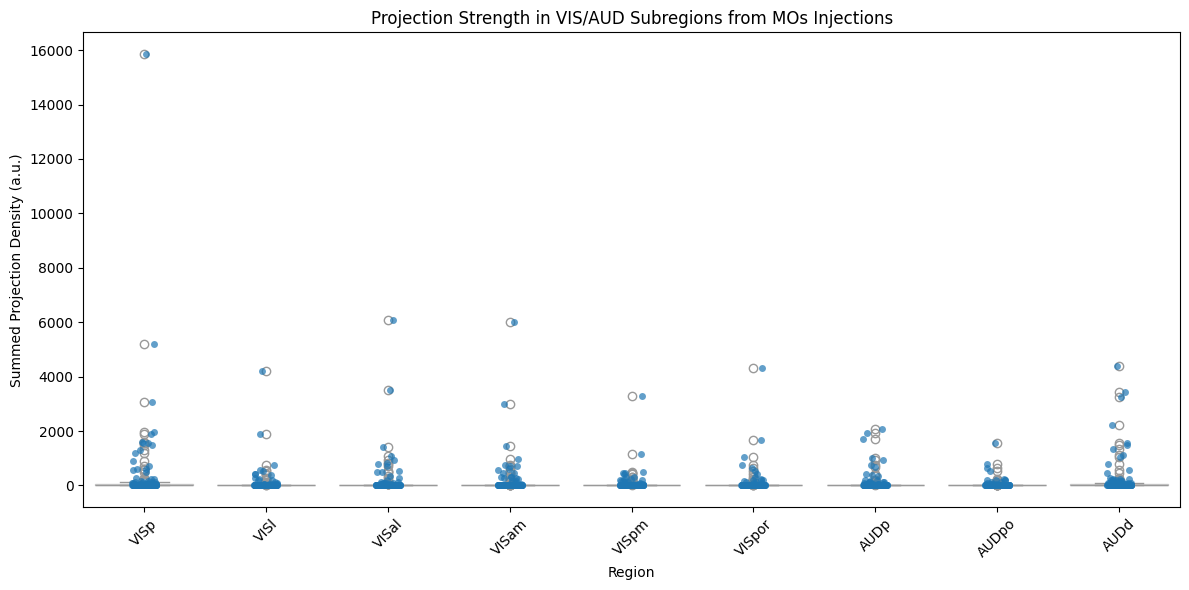

In [79]:
# --- Plot ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long, x="Region", y="ProjectionDensitySum",
            color='white', boxprops=dict(facecolor='none', alpha=0.5))
sns.stripplot(data=df_long, x="Region", y="ProjectionDensitySum",
              alpha=0.7, jitter=True)

plt.title("Projection Strength in VIS/AUD Subregions from MOs Injections")
plt.ylabel("Summed Projection Density (a.u.)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
